In [1]:
!pip install datasets
!pip install noisereduce
!pip install tensorflow
!pip install jiwer
!pip install librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.3 MB/s eta 0:00:0000:0100:01


In [3]:
import os
import random
import math
from IPython.display import Audio, display
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, Model, callbacks, optimizers, losses
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import librosa
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, SubsetRandomSampler
from tensorflow.keras import layers, models, optimizers
from dataclasses import dataclass
from typing import List, Dict
import torchaudio
from torch.utils.tensorboard import SummaryWriter
import noisereduce as nr
from transformers import Wav2Vec2Processor
from typing import Tuple
from typing import Tuple, Optional
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


In [4]:
# Set up GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available")
    except RuntimeError as e:
        print(e)
else:
    print("GPU is not available, using CPU")

GPU is available


In [6]:
base_path = "/kaggle/input/arabic-egy-asr-16k"
train_wavs_path = os.path.join(base_path, "train")
adapt_wavs_path = os.path.join(base_path, "adapt")
train_metadata_path = os.path.join(base_path, "train.csv")
adapt_metadata_path = os.path.join(base_path, "adapt.csv")

# **visualization data**

In [7]:
# Get a list of all files in the directory
files = os.listdir(train_wavs_path)

# Filter the list to include only .wav files
wav_files = [file for file in files if file.endswith('.wav')]

# Get the number of .wav files
num_wav_files = len(wav_files)

# Print the number of .wav files
print(f"Number of .wav files: {num_wav_files}")

# Print the names of 10 random .wav files
print("Names of 10 random .wav files:")
random_wav_files = random.sample(wav_files, 10)
for wav_file in random_wav_files:
    print(wav_file)

Number of .wav files: 50715
Names of 10 random .wav files:
train_sample_10454.wav
train_sample_44794.wav
train_sample_50179.wav
train_sample_10526.wav
train_sample_17760.wav
train_sample_45602.wav
train_sample_45334.wav
train_sample_12843.wav
train_sample_41546.wav
train_sample_6738.wav


In [8]:
metadata_df = pd.read_csv(train_metadata_path, delimiter=',')
adapt_metadata_df = pd.read_csv(adapt_metadata_path, delimiter=',')


In [9]:
# Get the number of rows and columns
num_rows, num_columns = metadata_df.shape

# Get the column names
column_names = metadata_df.columns.tolist()

# Print the number of columns and rows
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)
print("Column names:", column_names)

# Display the first 30 rows of the DataFrame
metadata_df.head(30)

Number of columns: 2
Number of rows: 50715
Column names: ['audio', 'transcript']


,audio,transcript
0,train_sample_0,على إنها عار في الوقت اللي كانت بتتعامل مع أخو...
1,train_sample_1,فأكيد ربنا عوضهم خير هو الراجل بيبقى ليه إختيا...
2,train_sample_2,زي دول كتيره بنشوفها النهارده في العالم وأصبحت...
3,train_sample_3,يعني مين اللي بيحط شروطها يعني أنا شايفه إني م...
4,train_sample_4,والله هي الموضوع مش كليب خلي بالك ولا أغنيه ال...
5,train_sample_5,خليها تعمل كده تعالوا نسمع الحكايه من أولها ون...
6,train_sample_6,إم دي اللي تقدر تفرق لاعيب من اللاعيب للاعيب ف...
7,train_sample_7,بتأتي في موعدها إحنا كمان يعني أنا مش هقول الح...
8,train_sample_8,ولا هو قدر يتغلب على صعاب معينه وقدر يتغلب على...
9,train_sample_9,لكن الحاج فهمي كان هو البدايه إن البدايه إنك إ...


In [10]:
# Get the number of rows and columns
num_rows, num_columns = adapt_metadata_df.shape

# Get the column names
column_names = adapt_metadata_df.columns.tolist()

# Print the number of columns and rows
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)
print("Column names:", column_names)

# Display the first 30 rows of the DataFrame
adapt_metadata_df.head(30)

Number of columns: 2
Number of rows: 2199
Column names: ['audio', 'transcript']


,audio,transcript
0,adapt_sample_0_clean,شوفلنا المشوار ده يا حج
1,adapt_sample_1_clean,لأ للأسف دكتوره واحده بس بتعمل العمليه ديت عند...
2,adapt_sample_2_clean,والراجل تبصله يعني إبن زمنه
3,adapt_sample_3_clean,و أنت كيف عرفته أبترل يا عمي
4,adapt_sample_4_clean,ميعرفوش حاجه عن السوبر أه غير إنه لب
5,adapt_sample_5_clean,أه نمره اتنين يوم الجمعه بيجولنا البنات
6,adapt_sample_6_clean,خربت بيتنا يا وكلاهم
7,adapt_sample_7_clean,وبعدين واد ولا بت ما تفرقش المهم الربايه الزينه
8,adapt_sample_8_clean,واترمت طبعا
9,adapt_sample_9_clean,الله يبعد عنك ولاد الحرام


# **Preprocessing**

In [11]:
# Define the set of characters accepted in the transcription
characters_arabic = [x for x in "ابتثجحخدذرزسشصضطظعغفقكلمنهويءآؤئ؟ًَُِّْ"]

# Mapping characters Arbic langunage to integers
char_to_num_arabic = keras.layers.StringLookup(vocabulary=characters_arabic, oov_token="")

# Mapping integers back to original characters Arbic char
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num_arabic.get_vocabulary(), oov_token="", invert=True
)

# Print the vocabulary and its size
print(
    f"The vocabulary is: {char_to_num_arabic.get_vocabulary()} "
    f"(size = {char_to_num_arabic.vocabulary_size()})"
)

The vocabulary is: ['', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'ء', 'آ', 'ؤ', 'ئ', '؟', 'ً', 'َ', 'ُ', 'ِ', 'ّ', 'ْ'] (size = 40)


Shape of the STFT output: (718, 193)
Shape of the magnitude of the STFT: (718, 193)
Sample rate: 16000
Audio signal shape: (115040,)
Audio duration: 7.19 seconds
Number of frames: 718
Shape of frames array: (718, 256)


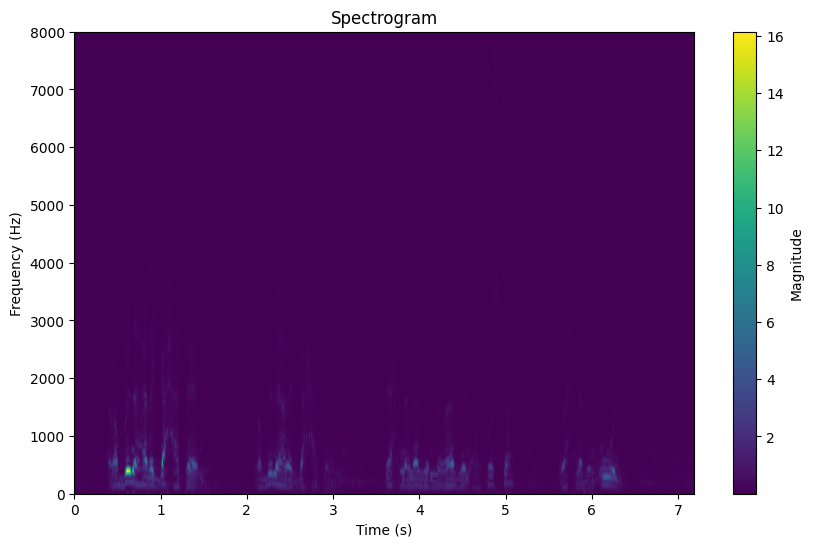

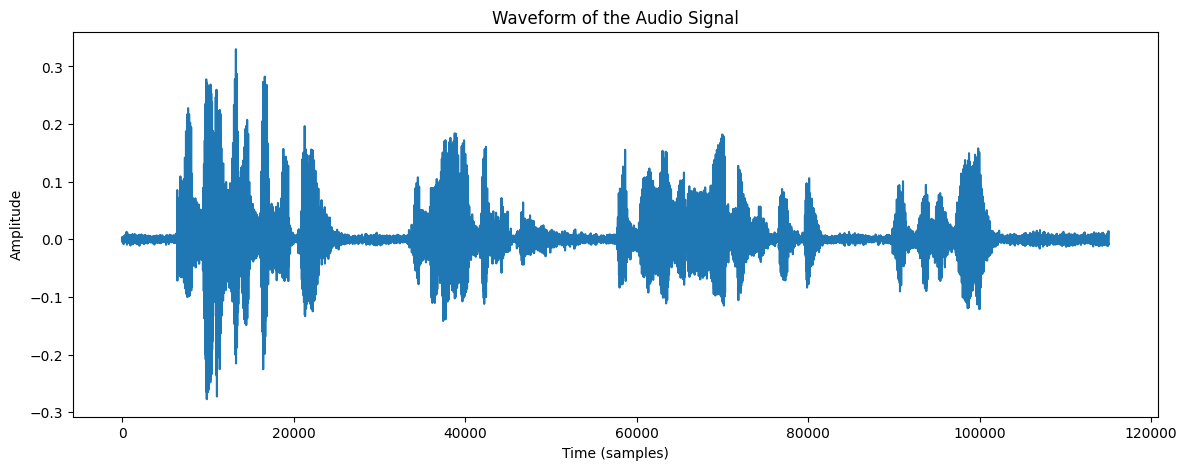

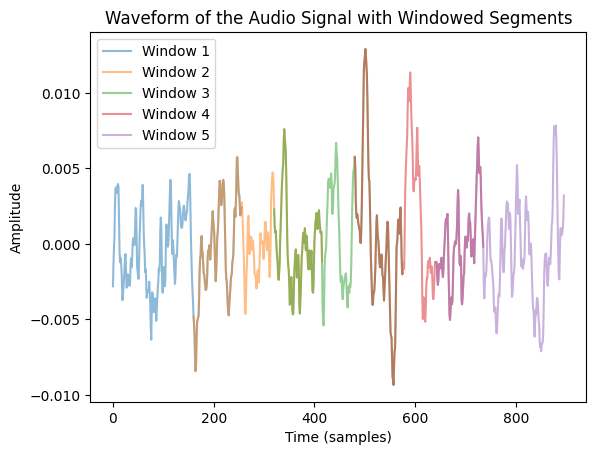

In [13]:
# Load the audio file
audio_path = '/kaggle/input/arabic-egy-asr-16k/train/train_sample_10017.wav'
audio_signal, sample_rate = librosa.load(audio_path, sr=None)

# Parameters for STFT
frame_length = 256  # Window length in samples
frame_step = 160    # Number of samples to step
fft_length = 384    # FFT length

# Convert audio signal to a tensor
audio_tensor = tf.convert_to_tensor(audio_signal, dtype=tf.float32)

# Applying STFT
stft = tf.signal.stft(audio_tensor, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

# The magnitude of the STFT
magnitude = tf.abs(stft)

# Create windows
num_frames = 1 + (len(audio_signal) - frame_length) // frame_step
frames = np.lib.stride_tricks.sliding_window_view(audio_signal, frame_length)[::frame_step]


# Print the shape of the STFT output
print(f"Shape of the STFT output: {stft.shape}")
print(f"Shape of the magnitude of the STFT: {magnitude.shape}")

#And Print some basic information about the audio signal
print(f"Sample rate: {sample_rate}")
print(f"Audio signal shape: {audio_signal.shape}")
print(f"Audio duration: {len(audio_signal) / sample_rate:.2f} seconds")

print(f"Number of frames: {num_frames}")
print(f"Shape of frames array: {frames.shape}")

# Plot the magnitude of the STFT
plt.figure(figsize=(10, 6))
plt.imshow(tf.transpose(magnitude).numpy(), aspect='auto', origin='lower',
           extent=[0, len(audio_signal)/sample_rate, 0, sample_rate/2])
plt.title('Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar(label='Magnitude')
plt.show()


# Plot the waveform of the audio signal
plt.figure(figsize=(14, 5))
plt.plot(audio_signal)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

# Plot a few windowed segments
num_windows_to_plot = 5
for i in range(num_windows_to_plot):
    start_index = i * frame_step
    windowed_segment = audio_signal[start_index:start_index + frame_length]
    plt.plot(range(start_index, start_index + frame_length), windowed_segment, alpha=0.5, label=f'Window {i+1}')

plt.title('Waveform of the Audio Signal with Windowed Segments')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [14]:
df_train = metadata_df
df_valid = adapt_metadata_df

In [15]:
def encode_single_sample(wav_file, label):
    # Reading the audio file
    #فك تشفيره باستخدام "tf.audio.decode_wav"
    audio, _ = tf.audio.decode_wav(tf.io.read_file(wav_file))

    # Removing extra dimension
    audio = tf.squeeze(audio, axis=-1)

    # Changing type to float
    audio = tf.cast(audio, tf.float32)

    # Getting the spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

    # Taking the magnitude
    spectrogram = tf.abs(spectrogram)

    # Applying power to the spectrogram
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # Normalization
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    # Process the label
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')
    label = char_to_num_arabic(label)

    return spectrogram, label

In [16]:
# Batch size
batch_size = 64

# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    list(df_train['audio'].astype(str)),
    list(df_train['transcript'].astype(str))
))

# Prepend the directory path to the file names
train_dataset = train_dataset.map(
    lambda x, y: (tf.strings.join([train_wavs_path, "/", x, ".wav"]), y)
)

# Encode each sample in the dataset
train_dataset = train_dataset.map(
    lambda x, y: encode_single_sample(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Batch and prefetch for efficiency
train_dataset = train_dataset.padded_batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
# Define the adaptation dataset (validation dataset)
adapt_dataset = tf.data.Dataset.from_tensor_slices((
    list(df_valid['audio'].astype(str)),
    list(df_valid['transcript'].astype(str))
))

# Prepend the directory path to the file names
adapt_dataset = adapt_dataset.map(
    lambda x, y: (tf.strings.join([adapt_wavs_path, "/", x, ".wav"]), y)
)

# Encode each sample in the dataset
adapt_dataset = adapt_dataset.map(
    lambda x, y: encode_single_sample(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Batch and prefetch for efficiency
adapt_dataset = adapt_dataset.padded_batch(batch_size)
adapt_dataset = adapt_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


File path: /kaggle/input/arabic-egy-asr-16k/train/train_sample_0.wav


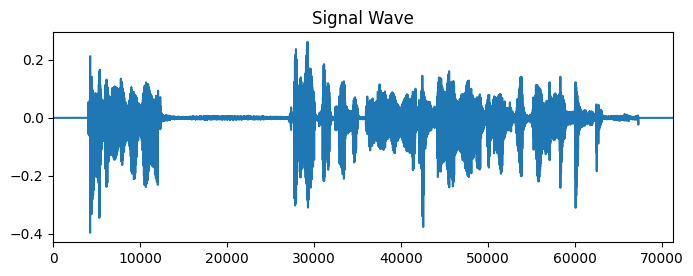

In [19]:
# Plotting settings
fig = plt.figure(figsize=(8, 6))

# Take one batch from the training dataset
for batch in train_dataset.take(1):
    # Get the first spectrogram and label in the batch
    spectrogram = batch[0][0].numpy()
    label = batch[1][0]

    # Process the spectrogram
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])

    # Convert label from numbers to text
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")

    # Construct the file path
    wav_file_name = list(df_train["audio"])[0] + ".wav"
    wav_file_path = "/kaggle/input/arabic-egy-asr-16k/train/" + wav_file_name
    print("File path:", wav_file_path)  # Print the file path for verification

    # Check if the file exists
    if not os.path.exists(wav_file_path):
        print(f"File {wav_file_path} does not exist.")
        continue

    # Load audio using librosa
    audio, sr = librosa.load(wav_file_path, sr=10000)

    # Display audio
    display.display(display.Audio(np.transpose(audio), rate=10000))


    # Plot the waveform
    ax = plt.subplot(2, 1, 2)
    ax.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))

    # Display audio
    plt.show()

In [20]:
# Ensure all values in 'transcript' column are strings and handle NaN values
metadata_df['transcript'] = metadata_df['transcript'].astype(str).fillna('')

# Combine all words into a single list
all_words = ' '.join(metadata_df['transcript']).split()

# Count occurrences of each unique word
word_counts = Counter(all_words)

# Set a VOCAB_SIZE
VOCAB_SIZE = len(word_counts)

# Create a DataFrame from the word counts
unique_words_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])

# Sort the DataFrame by count (descending) and then by word (ascending)
unique_words_df = unique_words_df.sort_values(by=['Count', 'Word'], ascending=[False, True]).sort_index()

# Print VOCAB_SIZE
print(VOCAB_SIZE)

# Display the sorted DataFrame
unique_words_df.head(30)

69062


,Word,Count
0,على,7186
1,إنها,435
2,عار,6
3,في,20250
4,الوقت,608
5,اللي,9348
6,كانت,1509
7,بتتعامل,12
8,مع,2590
9,أخويا,62


# **feature extraction**

In [3]:
def extract_features(file_path, sr=16000, n_mfcc=13):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs = mfccs.T
        return mfccs
    except Exception as e:
        print(f"Error in extract_features for file {file_path}: {str(e)}")
        return None

# **Loading Data**

In [4]:
def load_data(metadata_path, wavs_path, max_transcript_length=280):
    df = pd.read_csv(metadata_path)
    X = []
    y = []
    max_len = 0
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading data"):
        file_name = row['audio']
        file_path = os.path.join(wavs_path, file_name + '.wav')

        if pd.isna(row['transcript']) or (isinstance(row['transcript'], str) and len(row['transcript']) > max_transcript_length):
            continue

        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            continue

        try:
            features = extract_features(file_path)

            if features is None or np.isnan(features).any():
                print(f"Warning: Invalid features for file: {file_path}")
                continue

            max_len = max(max_len, features.shape[0])
            X.append(features)
            y.append(row['transcript'])
        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")

    return X, y, max_len

In [5]:
def pad_features(features, max_len):
    if features.shape[0] < max_len:
        return np.pad(features, ((0, max_len - features.shape[0]), (0, 0)), mode='constant')
    else:
        return features[:max_len, :]

In [6]:
# Load and preprocess data
print("Loading training data...")
X_train, y_train, train_max_len = load_data(train_metadata_path, train_wavs_path, max_transcript_length=280)
print("Loading adaptation data...")
X_adapt, y_adapt, adapt_max_len = load_data(adapt_metadata_path, adapt_wavs_path, max_transcript_length=280)


Loading training data...


Loading data: 100%|██████████| 50715/50715 [34:12<00:00, 24.70it/s]


Loading adaptation data...


Loading data: 100%|██████████| 2199/2199 [01:19<00:00, 27.71it/s]


In [7]:
max_len = max(train_max_len, adapt_max_len)
print(f"Maximum sequence length: {max_len}")

# Pad sequences
X_train = [pad_features(x, max_len) for x in X_train]
X_adapt = [pad_features(x, max_len) for x in X_adapt]

# Use all adapt data for validation
X_val = X_adapt
y_val = y_adapt

# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of validation samples: {len(y_val)}")


Maximum sequence length: 1082
Shape of X_train: (50709, 1082, 13)
Shape of X_val: (2190, 1082, 13)
Number of training samples: 50709
Number of validation samples: 2190


In [9]:
# Create character mappings
chars = set(''.join(y_train + y_val))
char_to_index = {char: i for i, char in enumerate(sorted(chars))}
index_to_char = {i: char for char, i in char_to_index.items()}
vocab_size = len(char_to_index)

max_transcript_len = max(len(t) for t in y_train + y_val)


# **Modeling**

In [10]:
def data_generator(X, y, batch_size, augment=False):
    num_samples = len(X)
    while True:
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            X_batch = [X[i] for i in batch_indices]
            y_batch = [y[i] for i in batch_indices]

            X_processed = np.array([x if x.shape == (max_len, 13) else np.zeros((max_len, 13)) for x in X_batch])

            if augment:
                X_processed = np.array([augment_audio(x) for x in X_processed])

            y_processed = [[char_to_index.get(char, 0) for char in text] for text in y_batch]
            y_padded = pad_sequences(y_processed, maxlen=max_transcript_len, padding='post', value=-1)  # Use -1 for padding

            yield X_processed, y_padded

In [11]:
def augment_audio(spec):
    factor = np.random.uniform(0.8, 1.2)
    spec = librosa.effects.time_stretch(spec.T, rate=factor).T

    if spec.shape[0] > max_len:
        spec = spec[:max_len, :]
    elif spec.shape[0] < max_len:
        pad_width = ((0, max_len - spec.shape[0]), (0, 0))
        spec = np.pad(spec, pad_width, mode='constant')

    noise = np.random.randn(*spec.shape)
    spec_noisy = spec + 0.005 * noise

    return spec_noisy

In [12]:
def build_acoustic_model(input_shape, output_dim):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
        keras.layers.TimeDistributed(keras.layers.Dense(output_dim)),
        keras.layers.Activation('softmax')
    ])
    return model

In [13]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, -1), tf.int64), axis=-1)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = tf.expand_dims(label_length, axis=-1)

    # Ensure input_length is always greater than or equal to label_length
    input_length = tf.maximum(input_length, label_length + 1)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [14]:
# Build and compile the acoustic model
input_shape = (max_len, 13)
am = build_acoustic_model(input_shape, vocab_size + 1)  # +1 for the blank symbol
am.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=ctc_loss, run_eagerly=True)


In [15]:
# Set up data generators
batch_size = 16
train_gen = data_generator(X_train, y_train, batch_size, augment=True)
val_gen = data_generator(X_val, y_val, batch_size, augment=False)

# Training
epochs = 4
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size


In [16]:
def lm_data_generator(y, batch_size):
    num_samples = len(y)
    while True:
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            y_batch = [y[i] for i in batch_indices]

            # Convert characters to indices
            y_processed = [[char_to_index.get(char, 0) for char in text] for text in y_batch]
            y_padded = pad_sequences(y_processed, maxlen=max_transcript_len, padding='post', truncating='post')

            # Create input and output for language model
            X_lm = y_padded[:, :-1]  # Input: all characters except the last one
            y_lm = y_padded[:, 1:]   # Output: all characters except the first one

            yield X_lm, y_lm

In [17]:
def build_language_model(vocab_size, max_length, embed_dim=64, rnn_units=128):
    model = keras.Sequential([
        keras.layers.Input(shape=(max_length - 1,)),  # -1 because we're not including the last character in input
        keras.layers.Embedding(vocab_size, embed_dim),
        keras.layers.LSTM(rnn_units, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation='softmax'))
    ])
    return model

In [18]:
# Build and compile the language model
lm = build_language_model(vocab_size, max_transcript_len)
lm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [19]:
# Set up data generators for the language model
lm_train_gen = lm_data_generator(y_train, batch_size)
lm_val_gen = lm_data_generator(y_val, batch_size)


In [20]:
import os
from tensorflow.keras.models import load_model

# Load the acoustic model
base_path = "/kaggle/input/train-1" 

am_load_path = os.path.join(base_path, 'acoustic_model_train_1.h5')
am = load_model(am_load_path, custom_objects={'ctc_loss': ctc_loss})
print(f"Acoustic model loaded from {am_load_path}")

# Load the language model
lm_load_path = os.path.join(base_path, 'language_model_train_1.h5')
lm = load_model(lm_load_path)
print(f"Language model loaded from {lm_load_path}")

Acoustic model loaded from /kaggle/input/train-1/acoustic_model_train_1.h5
Language model loaded from /kaggle/input/train-1/language_model_train_1.h5


In [27]:
# Recompile the model
am.compile(optimizer='adam', loss=ctc_loss, run_eagerly=True)

In [28]:
# Train the acoustic model
am_history = am.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ],
    verbose=1
)

Epoch 1/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 8568s 3s/step - loss: 111.2869 - val_loss: 95.7938 - learning_rate: 0.0010
Epoch 2/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 8622s 3s/step - loss: 108.0332 - val_loss: 95.2723 - learning_rate: 0.0010
Epoch 3/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 8618s 3s/step - loss: 104.0170 - val_loss: 94.9950 - learning_rate: 0.0010
Epoch 4/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 8619s 3s/step - loss: 101.7641 - val_loss: 94.1140 - learning_rate: 0.0010


In [29]:
import os
from tensorflow.keras.models import load_model

base_path = "/kaggle/working" 

# Save the acoustic model
am_save_path = os.path.join(base_path, 'acoustic_model_train_2.h5')
am.save(am_save_path)
print(f"Acoustic model saved to {am_save_path}")

Acoustic model saved to /kaggle/working/acoustic_model_train_2.h5


In [31]:
lm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Train the language model
lm_history = lm.fit(
    lm_train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=lm_val_gen,
    validation_steps=validation_steps,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1)
    ]
)

Epoch 1/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 139s 39ms/step - accuracy: 0.8740 - loss: 0.4432 - val_accuracy: 0.9098 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 2/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 120s 38ms/step - accuracy: 0.8757 - loss: 0.4366 - val_accuracy: 0.9109 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 3/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 121s 38ms/step - accuracy: 0.8770 - loss: 0.4314 - val_accuracy: 0.9106 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 4/4
3169/3169 ━━━━━━━━━━━━━━━━━━━━ 120s 38ms/step - accuracy: 0.8781 - loss: 0.4273 - val_accuracy: 0.9118 - val_loss: 0.3095 - learning_rate: 0.0010


In [33]:
# Save the language model
lm_save_path = os.path.join(base_path, 'language_model_train_2.h5')
lm.save(lm_save_path)
print(f"Language model saved to {lm_save_path}")

Language model saved to /kaggle/working/language_model_train_2.h5


In [21]:
base_path = "/kaggle/input/trainn-2" 

# Load the acoustic model
am_load_path = os.path.join(base_path, 'acoustic_model_train_2.h5')
am = load_model(am_load_path, custom_objects={'ctc_loss': ctc_loss})
print(f"Acoustic model loaded from {am_load_path}")

# Load the language model
lm_load_path = os.path.join(base_path, 'language_model_train_2.h5')
lm = load_model(lm_load_path)
print(f"Language model loaded from {lm_load_path}")

Acoustic model loaded from /kaggle/input/trainn-2/acoustic_model_train_2.h5
Language model loaded from /kaggle/input/trainn-2/language_model_train_2.h5
